## Challenge 1: Titanic - Train after FE

### Import thư viện và đọc dữ liệu

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import random

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

Tham số thực nghiệm

In [2]:
### Tham số thực nghiệm
params = {}

params["exps_dir"] = "../exps"
params["exp_name"] = "challenge1_titanic_standard"

params["exps_root"] = f'{params["exps_dir"]}/result1_standard'
params["save_dir"] = f'{params["exps_dir"]}/result1_{params["exp_name"]}'

params["data_path"] = f'{params["exps_dir"]}/data'

params["k_fold"] = 10
params["random_state"] = 42

random.seed(params["random_state"])
os.environ['PYTHONHASHSEED'] = str(params["random_state"])
np.random.seed(params["random_state"])

In [3]:
# Đọc dữ liệu sau Feature Engineering
train = pd.read_excel(f"{params["data_path"]}/train_feat.xlsx")
valid = pd.read_excel(f"{params["data_path"]}/valid_feat.xlsx")
test = pd.read_excel(f"{params["data_path"]}/test_feat.xlsx")

print("Đọc dữ liệu thành công:", train.shape, valid.shape, test.shape)
train.head()

Đọc dữ liệu thành công: (712, 16) (179, 16) (418, 15)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,HasCabin,Deck,Title,FamilySize,IsAlone,AgeBin,FareBin
0,0,1,1,0.566474,0,0,0.055628,56,2,1,C,Mr,1,1,Adult,High
1,0,2,1,0.283740,0,0,0.025374,147,2,0,U,Mr,1,1,YoungAdult,Mid
2,0,3,1,0.396833,0,0,0.015469,147,2,0,U,Mr,1,1,Adult,Low
3,0,3,1,0.321438,1,0,0.015330,147,2,0,U,Mr,2,0,YoungAdult,Low
4,0,3,0,0.070118,4,2,0.061045,147,2,0,U,Miss,7,0,Child,VeryHigh


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    712 non-null    int64  
 1   Pclass      712 non-null    int64  
 2   Sex         712 non-null    int64  
 3   Age         712 non-null    float64
 4   SibSp       712 non-null    int64  
 5   Parch       712 non-null    int64  
 6   Fare        712 non-null    float64
 7   Cabin       712 non-null    int64  
 8   Embarked    712 non-null    int64  
 9   HasCabin    712 non-null    int64  
 10  Deck        712 non-null    object 
 11  Title       712 non-null    object 
 12  FamilySize  712 non-null    int64  
 13  IsAlone     712 non-null    int64  
 14  AgeBin      571 non-null    object 
 15  FareBin     712 non-null    object 
dtypes: float64(2), int64(10), object(4)
memory usage: 89.1+ KB


### Xử lý dữ liệu trước khi train

In [5]:
# Loại bỏ cột không cần thiết
drop_cols = ["Ticket", "Cabin", "SibSp", "Parch"]
for col in drop_cols:
    if col in train.columns:
        train.drop(columns=col, inplace=True, errors="ignore")
        valid.drop(columns=col, inplace=True, errors="ignore")
        test.drop(columns=col, inplace=True, errors="ignore")

# Xử lý các cột phân loại (Label Encoding)
cat_cols = train.select_dtypes(include="object").columns
le = LabelEncoder()
for col in cat_cols:
    all_vals = pd.concat([train[col], valid[col], test[col]], axis=0).astype(str)
    le.fit(all_vals)

    train[col] = le.transform(train[col].astype(str))
    valid[col] = le.transform(valid[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

print("Hoàn tất xử lý dữ liệu trước train")
train.head()

Hoàn tất xử lý dữ liệu trước train


,Survived,Pclass,Sex,Age,Fare,Embarked,HasCabin,Deck,Title,FamilySize,IsAlone,AgeBin,FareBin
0,0,1,1,0.566474,0.055628,2,1,2,2,1,1,0,0
1,0,2,1,0.283740,0.025374,2,0,8,2,1,1,4,2
2,0,3,1,0.396833,0.015469,2,0,8,2,1,1,0,1
3,0,3,1,0.321438,0.015330,2,0,8,2,2,0,4,1
4,0,3,0,0.070118,0.061045,2,0,8,1,7,0,1,3


### Tách biến mục tiêu

In [6]:
X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]
X_valid = valid.drop("Survived", axis=1)
y_valid = valid["Survived"]

print("X_train:", X_train.shape, "| X_val:", X_valid.shape)

X_train: (712, 12) | X_val: (179, 12)


### Train & đánh giá nhiều mô hình

In [7]:
kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])
print(f"+ X_train: {len(X_train)}")
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fold {fold}: ')
    print(f'+ train_idx: {train_idx}')
    print(f'+ valid_idx: {valid_idx}')
    print(f'+ train / valid: {valid_idx}')
    pass

+ X_train: 712
Fold 0: 
+ train_idx: [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  50  51  52  53  55  56  57
  58  59  60  61  62  64  66  67  68  69  70  71  73  74  75  76  78  79
  80  82  83  85  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 119
 121 122 123 124 125 126 127 128 129 130 132 133 134 137 138 139 140 141
 142 143 144 146 147 149 150 151 152 153 154 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 197 198 199
 200 201 202 203 204 205 206 207 211 212 213 214 216 217 218 219 220 221
 222 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 240 241
 242 243 244 245 246 248 249 250 251 252 253 254 255 256 258 259 260 261
 262 263 264 2

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

results = []
baseline_results = {}

for name,model in models.items():
    baseline_results[name] = {"acc":[],"prec":[],"rec":[],"f1":[]}

    print(f'Model {name}:')

    kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])

    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
        X1_train, y1_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X1_valid, y1_valid = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        model.fit(X1_train,y1_train)

        y_pred_valid = model.predict(X1_valid)

        acc = accuracy_score(y1_valid, y_pred_valid)
        prec = precision_score(y1_valid, y_pred_valid)
        rec = recall_score(y1_valid, y_pred_valid)
        f1 = f1_score(y1_valid, y_pred_valid)

        baseline_results[name]["acc"].append(acc)
        baseline_results[name]["prec"].append(prec)
        baseline_results[name]["rec"].append(rec)
        baseline_results[name]["f1"].append(f1)
        pass

    # hiển thị tham số mô hình
    print(f'+ params = {model.get_params()}')

    # hiển thị kết quả trên từng fold
    print(f'+ acc = {baseline_results[name]["acc"]}')

    # trung bình kết quả +/ std cho tất cả các fold,
    # std: độ lệch chuẩn=> nếu cùng mean thì độ lệch nào nhỏ hơn thì tốt hơn vì ổn định và tập trung hơn
    s_msg = f'+ mean_acc = {np.mean(baseline_results[name]["acc"]):.6f} +/- {np.std(baseline_results[name]["acc"]):.6f}'
    print(s_msg)
    print()

    results.append([
        name,
        np.mean(baseline_results[name]["acc"]),
        np.mean(baseline_results[name]["prec"]),
        np.mean(baseline_results[name]["rec"]),
        np.mean(baseline_results[name]["f1"])
    ])
    #print(classification_report(y1_valid, y_pred_valid, digits=4))

Model Logistic Regression:
+ params = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
+ acc = [0.8472222222222222, 0.7638888888888888, 0.8028169014084507, 0.7183098591549296, 0.7746478873239436, 0.8169014084507042, 0.8873239436619719, 0.8169014084507042, 0.8309859154929577, 0.8169014084507042]
+ mean_acc = 0.807590 +/- 0.044412

Model Decision Tree:
+ params = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
+ acc = [0.7638888888888888, 0.75, 0.7464788732394366, 0.7605633802816901, 0.6901408450704225, 0.77464

In [9]:
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
df_results = df_results.sort_values(by="F1", ascending=False)
display.display(df_results)

,Model,Accuracy,Precision,Recall,F1
3,Gradient Boosting,0.824452,0.788679,0.709963,0.746410
0,Logistic Regression,0.807590,0.764969,0.695254,0.724622
5,SVM,0.794992,0.733019,0.706629,0.717304
2,Random Forest,0.796303,0.747804,0.687202,0.713555
4,XGBoost,0.789300,0.733354,0.693438,0.708794
1,Decision Tree,0.757023,0.673598,0.666265,0.668539


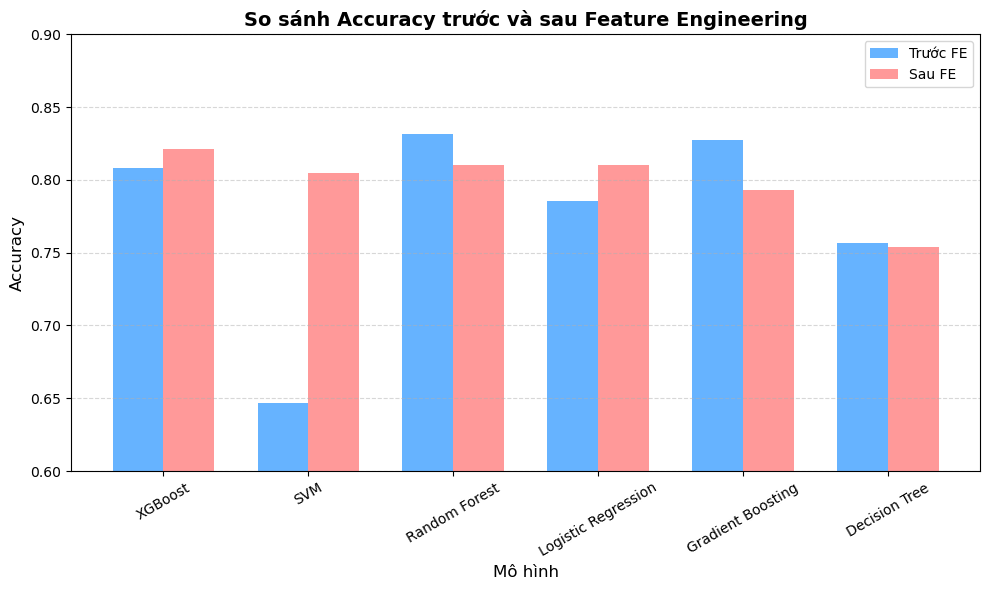

In [10]:
# So sánh Accuracy trước và sau Feature Engineering

import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu Accuracy
models_acc = ["XGBoost", "SVM", "Random Forest", "Logistic Regression", "Gradient Boosting", "Decision Tree"]
acc_before = [0.808077, 0.646442, 0.831610, 0.785618, 0.827166, 0.756492]
acc_after  = [0.821229, 0.804469, 0.810056, 0.810056, 0.793296, 0.754190]

x = np.arange(len(models_acc))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, acc_before, width, label="Trước FE", color="#66b3ff")
plt.bar(x + width/2, acc_after, width, label="Sau FE", color="#ff9999")

plt.xlabel("Mô hình", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("So sánh Accuracy trước và sau Feature Engineering", fontsize=14, fontweight="bold")
plt.xticks(x, models_acc, rotation=30)
plt.ylim(0.6, 0.9)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

**Nhận xét**

Sau khi thêm các đặc trưng mới như Title, FamilySize, IsAlone, và các biến tương tác khác, kết quả cho thấy:
 
- Một số mô hình cải thiện rõ rệt về độ chính xác (Accuracy) và cân bằng giữa Precision/Recall.

- SVM tăng mạnh nhất (+0.16 Accuracy), từ 0.64 → 0.80 — do mô hình này nhạy với đặc trưng phi tuyến nên hưởng lợi từ các đặc trưng mới có tính phân biệt cao.

- Logistic Regression và XGBoost cũng cải thiện nhẹ, chứng tỏ các đặc trưng mới giúp mô hình tuyến tính nhận diện tốt hơn giữa nhóm sống và không sống.

- Random Forest và Gradient Boosting hơi giảm nhẹ (khoảng -0.02 đến -0.03).
→ Có thể do các mô hình này đã tự động khai thác quan hệ phi tuyến giữa biến gốc, nên việc thêm đặc trưng mới không tạo ra khác biệt lớn, thậm chí gây dư thừa nhẹ.

**Tổng quan:**

- Feature Engineering tăng độ ổn định giữa các mô hình.

- Kết quả cao nhất đạt 0.82 Accuracy (XGBoost) sau FE — cho thấy tiềm năng khi kết hợp FE + tinh chỉnh tham số (hyperparameter tuning).

### Huấn luyện lại mô hình tốt nhất trên toàn bộ tập train để chuẩn bị lưu

In [11]:
best_model = GradientBoostingClassifier(random_state=params["random_state"])
best_model.fit(X_train, y_train)

# Đánh giá lại trên tập validation
y_pred_valid = best_model.predict(X_valid)

print("Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("Precision:", precision_score(y_valid, y_pred_valid))
print("Recall:", recall_score(y_valid, y_pred_valid))
print("F1-score:", f1_score(y_valid, y_pred_valid))
print(classification_report(y_valid, y_pred_valid))

Accuracy: 0.8212290502793296
Precision: 0.8
Recall: 0.7567567567567568
F1-score: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [13]:
# Lấy mô hình có Accuracy cao nhất
best_model_name = df_results.iloc[0]["Model"]
print(f"Mô hình tốt nhất theo Accuracy: {best_model_name}")

# Lấy đối tượng model tương ứng
best_model = models[best_model_name]

# Huấn luyện lại trên toàn bộ dữ liệu train
best_model.fit(X_train, y_train)

# Lưu file mô hình 
import pickle
model_filename = f"{best_model_name.replace(' ', '_')}_best.pkl"
pickle.dump(best_model, open(model_filename, "wb"))

print(f"Đã lưu mô hình tại: {model_filename}")

Mô hình tốt nhất theo Accuracy: Gradient Boosting
Đã lưu mô hình tại: Gradient_Boosting_best.pkl
